$
    \dfrac{\partial A}{\partial t} = (1 - ic)(1 - |A|^2)A + (i + d)\left(\dfrac{\partial^2 A}{\partial x^2}+\dfrac{\partial^2 A}{\partial y^2}\right) + 4i\left(m_x \cos(q_x x) + m_y \cos(q_y y) \right)\cos(\Omega t)A
$,

$A(t,x,y)$ - signal  
$x,y$ - signal displacement  
$t$ - time  
$c, d$ - alterable parameters  
$i$ - imaginary unit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from tqdm import tqdm
import os
import torch
from matplotlib.colors import LogNorm
import random
import gymnasium as gym

In [2]:
dims = "1D"
c = 0.5
gamma = 1. - c*1.j

#1D
d = 0.0
N = 12871
x_max = 128.0*np.pi
#2D
#d = 0.01
#N = 213
#x_max = 5

In [3]:
def generate_domains(dims):
    if N%2 == 0:
        print("please make N an odd number")
        return 0, 0
    domain = np.linspace(-x_max, x_max, N)
    dx = (domain[1]-domain[0])
    f_domain = np.fft.fftfreq(domain.shape[0], dx)
    if dims == "1D":
        x = [domain]
        omega = [f_domain]
    elif dims == "2D":
        x = np.meshgrid(domain, domain)
        omega = np.meshgrid(f_domain, f_domain)
    else:
        print("only 1D or 2D in dims")
        return 0, 0
    print("dx:", dx)
    print("k_max: ", f_domain[len(f_domain)//2])
    print("k_min: ", f_domain[len(f_domain)//2+1])
    return x, omega


def initial_conditions(shape):
    A = np.ones(shape, dtype=np.complex128)
    A.imag = 1.
    return A


def plot_data(dims, data):
    if dims == "1D":
        #plt.figure(figsize=(9, 9))
        plt.plot(data)
    elif dims == "2D":
        #plt.figure(figsize=(9, 9))
        plt.imshow(data)
        plt.colorbar()
    else:
        print("only 1D or 2D in dims")
    return


def add_perturb_1D(A, a, k, func, real, x):
    res = copy(A)
    if real:
        res.real += a*func(k*x)
    else:
        res.imag += a*func(k*x)
    return res


def add_noize(A):
    return A + 0.1*np.random.rand(*A.shape)


def save_iteration(A, i): 
    path1 = 'iterations/raw'
    try:
        os.makedirs(path1)
    except FileExistsError:
        pass
    
    path2 = 'iterations/fft'
    try:
        os.makedirs(path2)
    except FileExistsError:
        pass
    B = np.fft.fftshift(np.fft.fft2(A))
    if i==93:
        path3 = 'iterations/res'
        try:
            os.makedirs(path3)
        except FileExistsError:
            pass
        np.savetxt(path3+"/res_raw.txt", np.abs(A))

        np.savetxt(path3+"/res_fft.txt", np.abs(B))

    plt.figure(figsize=(10, 10))
    plt.imshow(np.abs(A))
    plt.colorbar()
    plt.title('|A|^2 at timestep {0}'.format(i))
    plt.savefig(path1 + '/{0:0{width}}.png'.format(i, width=3))
    plt.close()
    
    
    plt.figure(figsize=(10, 10))
    plt.imshow( np.abs(B), vmin=0.0, vmax=15.0)
    plt.colorbar()
    plt.title('A spectrum at timestep {0}'.format(i))
    plt.savefig(path2 + '/{0:0{width}}.png'.format(i, width=3))
    plt.close()
    return

def get_1D(data):
    res = data
    if res.ndim == 2:
        res = data[0]
    elif data.ndim < 1 or data.ndim > 2:
        print("either 2 or 1 ndims")
    return res

def check_perturbation(data, x, omega, ampl, freq):
    data = get_1D(data)
    x = get_1D(x)
    omega = get_1D(omega)
    perturb_0 = add_perturb_1D(data, ampl, freq*2*np.pi, np.cos, True, x)
    plt.figure()
    plt.plot(np.abs(perturb_0))
    plt.figure()
    plt.plot(np.fft.fftshift(omega), np.abs(np.fft.fftshift(np.fft.fft(perturb_0))))
    plt.xlim(-freq-1, freq+1)
    

In [4]:
x, omega = generate_domains(dims)

torch_x = []
torch_omega = []
for i in range(len(x)):
    torch_x.append(torch.from_numpy(x[i]))
    torch_omega.append(torch.from_numpy(omega[i]))

dx: 0.062490110281203215
k_max:  8.000644433651335
k_min:  -8.000644433651335


In [7]:
A_init = initial_conditions(x[0].shape)
A_noize = add_noize(A_init)

#plot_data(dims, np.abs(A_noize))
#check_perturbation(A_init, x[0], omega[0], 1., 2.)

In [8]:
def non_linear_step(A, m, q, Om, i, dt):
    temp = torch.empty(A.shape, dtype = torch.cfloat)
    potential = torch.zeros(A.shape, dtype = torch.cfloat)
    for j in range(len(m)):
        #formula potential
        potential += m[j]*torch.cos(q[j]*torch_x[j])
        #RL potential
        #action = modulation[i%13]
        #potential += (action-150)*0.01*torch.cos(q[j]*torch_x[j])
    #remove time modulation when doing RL
    torch.exp(((1. - torch.abs(A)**2)*gamma + 4.j*np.cos(dt*Om*i)*(potential) ) * dt, out=temp)
    return A*temp


def fft_step(A, multiplier):
    return A*multiplier


def computation_loop(A, i, m, q, Om, multiplier, dt):
    fft_func = torch.fft.fft if len(m)==1 else torch.fft.fft2
    ifft_func = torch.fft.ifft if len(m)==1 else torch.fft.ifft2
    A = fft_func(A)
    A = fft_step(A, multiplier)
    A = ifft_func(A)
    A = non_linear_step(A, m, q, Om, i, dt)
    A = fft_func(A)
    A = fft_step(A, multiplier)
    return ifft_func(A)


def full_loop(A, i, m, q, Om, multiplier, dt):
    res = computation_loop(A, i, m, q, Om, multiplier, dt)
    return res


def iterations(A, num, m, q, Om, a = 0, k = 0, func = 0, real = 0):
    st_perturb = False
    en_perturb = False

    perturb = False if a == 0 else True
    imgs_2D = True if  dims == "2D" else False
    img_1D = True if dims == "1D" else False
    if perturb:
        if imgs_2D:
            print("can't perturb 2D case")
            return 0, 0, 0
        img_1D = False

    dt = 0.04
    period = int(2*np.pi/Om/dt)
    #RL periods set yourself
    #period = 13
    n_frames = num//period
    img = 0
    #might want to uncomment the following line in RL
    dt = dt if (Om == 0) else 2*np.pi/Om/period
    multiplier = torch.empty(torch_omega[0].shape, dtype = torch.cfloat)
    temp = torch.zeros(A.shape, dtype = torch.cfloat)
    for i in range(len(m)):
        temp +=torch_omega[i]**2
    torch.exp(-(d+1.j)*(temp)*dt/2, out=multiplier);

    if not perturb:
        print("dt:", dt)
        print("period:", period, "n_frames:", n_frames)
        elems = tqdm(range(num))
    else:
        elems = range(num)
    #this is for RL
    #elems = range(num)

    l_array = []
    total_solution = []
    if perturb:
        l_array = np.zeros((2, A.shape[0]), dtype=complex)
    if img_1D:
        total_solution = np.zeros((n_frames, A.shape[0]))
    

    for i in elems:
        if img_1D and (i%period==period-1):
            total_solution[i//period] = np.copy(np.abs(A.numpy()))
        if imgs_2D:
            img += A.cpu().detach().numpy()
            if (i%period==period-1):
                save_iteration(img/period, i//period)
                img = 0
        
        if i > num*0.01 and perturb:
            if i%period==period-1 and not st_perturb:
                if perturb:
                    A = add_perturb_1D(A, a, k, func, real, torch_x[0])
                st_perturb = True    
            elif i%period==0 and st_perturb and not en_perturb:
                l_array[0] = np.copy(A.cpu().detach().numpy())
                en_perturb = True
            elif i%period==0 and en_perturb:
                l_array[1] = np.copy(A.cpu().detach().numpy())
                break
        
        A = full_loop(A, i, m, q, Om, multiplier, dt)

    return A, total_solution, l_array

In [23]:
# import pickle
# with open(r"actions_3.pickle", "rb") as output_file:
#      actions_backup = pickle.load(output_file)

In [9]:
num = 8000

#A_device = torch.tensor(A_init)
A_device = torch.tensor(A_noize)

A_device, heatmap_1D, lyapunov = iterations(A_device, num = num,
                                            #m = [0.3, 0.3], q = [2.*2*np.pi, 2.*2*np.pi], Om = 2.)
                                            m = [0.], q = [4.*2*np.pi], Om = 12.16)
                                            #m = [0.38], q = [4.*2*np.pi], Om = 10.4)
                                            #a = 0.0, k = 0.5*2*np.pi, func = torch.sin, real = True)

dt: 0.04305910983538642
period: 12 n_frames: 666


100%|██████████████████████████████████████| 8000/8000 [00:16<00:00, 472.10it/s]


In [10]:
#A_noize = A_device.numpy()

In [11]:
cutoff=2000
mets = []
res = np.abs(np.fft.fft(heatmap_1D, axis=1)[:, :])
for i in range(res.shape[0]):
    metric = np.sum(res[i][1:cutoff])/cutoff + np.sum(res[i][-cutoff:])/cutoff
    mets.append(metric)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


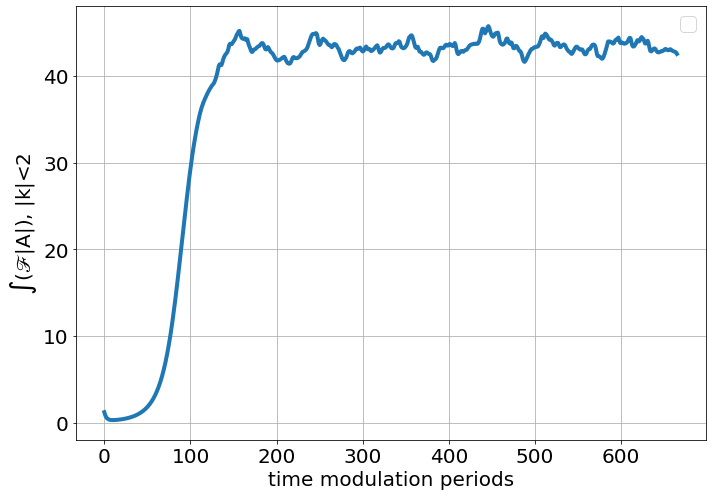

In [12]:
plt.figure(figsize=(10,7))
#plt.plot([], [], 'k ', label="RL modulation 2")
#plt.plot([], [], 'k ', label="$m = 0.72$, $Q = 0.76$")
plt.plot(np.array(mets), lw=4)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylabel("$\int(\mathscr{F}$|A|), |k|<2", fontsize=20)
plt.xlabel("time modulation periods", fontsize=20)
plt.tight_layout()
plt.grid()
plt.legend(fontsize=20)
plt.savefig("low_freq.png")

In [13]:
def plot_1D_heatmap(heatmap_1D):
    plt.figure(figsize=(10,10))
    plt.imshow(np.abs(heatmap_1D[:,1000:1000+heatmap_1D.shape[1]//8]), aspect='auto', origin="lower", cmap='binary_r', vmin=0.85, vmax=1.1)
    #plt.imshow(np.abs(heatmap_1D[:,:]), aspect='auto', origin="lower", cmap='binary_r', vmin=0.85, vmax=1.1)
    cb = plt.colorbar()
    cb.set_label(label='|A|',size=25)
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(20)
    ax = plt.gca()
    #plt.xlim(0, 32)
    ax.set_xticks(np.linspace(0, heatmap_1D.shape[1]/8, 9), np.linspace(0, int(2*x[0][-1]/8/np.pi), 9).astype(int), fontsize=20);
    ax.set_yticks(np.linspace(0, heatmap_1D.shape[0], 9), np.linspace(0, heatmap_1D.shape[0], 9).astype(int), fontsize=20);
    plt.xlabel("x in units of $\pi$", fontsize=25)
    plt.ylabel("t in time modulation periods", fontsize=25)
    plt.tight_layout()
    plt.savefig("unmodulated_x.png")
    
    
    plt.figure(figsize=(10,10))
    res = np.abs(np.fft.fft(heatmap_1D, axis=1)[:, :])

    #for i in range(res.shape[0]):
    #    res[i] = np.fft.fftshift(res[i])

    plt.imshow(res[:, : heatmap_1D.shape[1]//2], origin='lower', aspect='auto',  cmap='binary_r', vmin=0, vmax=25)
    cb = plt.colorbar()
    cb.set_label(label="$\mathscr{F}$ (|A|)",size=25)
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(20)

    ax = plt.gca()
    plt.xlabel("k", fontsize=25)
    plt.ylabel("t in time modulation periods", fontsize=25)
    ax.set_xticks(np.linspace(0, heatmap_1D.shape[1]//2, 5), np.linspace(0, int(omega[0][len(omega[0])//2]), 5).astype(int), fontsize=20);
    ax.set_yticks(np.linspace(0, heatmap_1D.shape[0], 9), np.linspace(0, heatmap_1D.shape[0], 9).astype(int), fontsize=20)
    plt.tight_layout()
    plt.savefig("unmodulated_sp.png")
    return

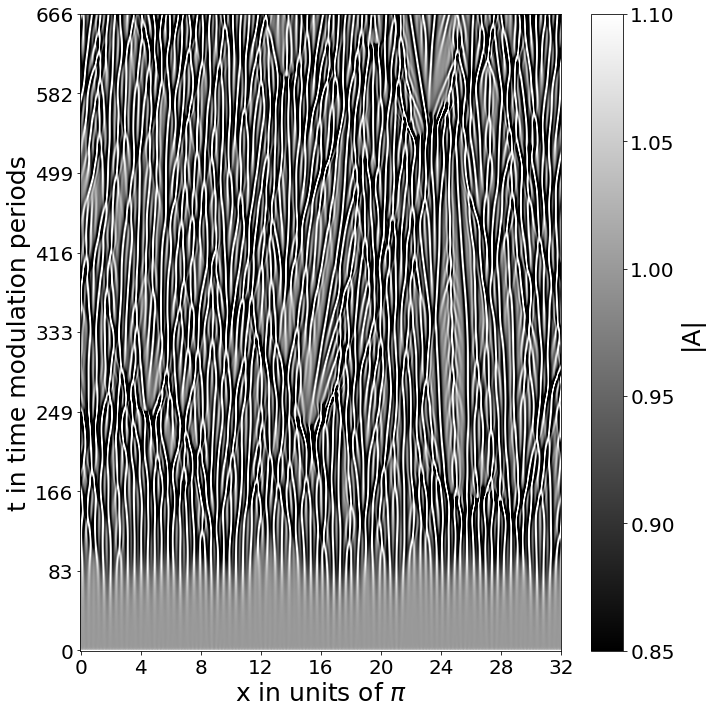

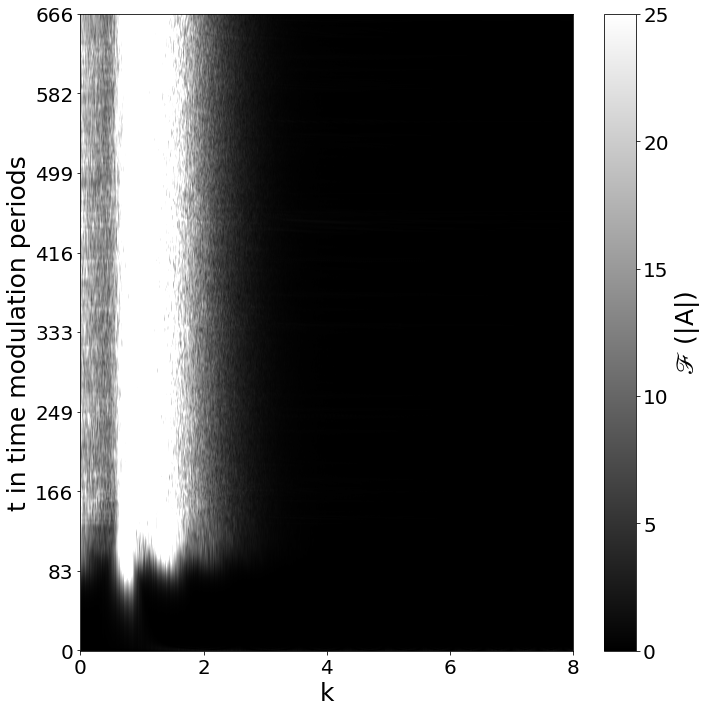

In [14]:
plot_1D_heatmap(heatmap_1D)

In [15]:
sp_ind = 3217
offset = 8

ks = omega[0][:len(omega[0])//2][omega[0][:len(omega[0])//2]<1.2][::offset]
num = 8000
q = 4.
harmonics = [0, q, -q, -2*q]
n_mat = 4*len(harmonics)
funcs = [torch.sin, torch.cos]
reals = [True, False]

In [16]:
totals = []

for k in tqdm(ks):
    for harm in harmonics:
        for real in reals:
            for func in funcs:
                A_device = torch.tensor(A_init)
                _, _, lyapunov = iterations(A_device, num = num,
                            m = [0.72], q = [q*2*np.pi], Om = 12.16,
                            a = 0.1, k = (k+harm)*2.*np.pi,
                            func = func, real = real)
                totals.append(np.copy(lyapunov))

100%|█████████████████████████████████████████| 121/121 [06:28<00:00,  3.21s/it]


In [27]:
def fill_matrix(ind, sp_ind, val):
    inds = [ind*offset, -ind*offset, 
            sp_ind+ind*offset, -sp_ind-ind*offset,
            sp_ind-ind*offset, -sp_ind+ind*offset,
            2*sp_ind-ind*offset, -2*sp_ind+ind*offset]

    m = np.zeros((n_mat,n_mat))
    for i in range(n_mat):
        for j in range(len(inds)):
            m[2*j, i] = np.fft.fft(totals[ind*n_mat+i][val]).real[inds[j]]
            m[2*j+1, i] = np.fft.fft(totals[ind*n_mat+i][val]).imag[inds[j]]

    return m

def get_lyapunov_coefs():
    l_components = np.zeros((len(ks)-1, 16))

    for i in tqdm(range(1, len(ks))):
        m0 = fill_matrix(i, sp_ind, 0)
        mT = fill_matrix(i, sp_ind, 1)
        m_new = np.matmul(np.linalg.inv(m0), mT)
        lambdas, _ = np.linalg.eig(m_new)
        res = (np.log(lambdas)/0.6).real
        l_components[i-1] = np.copy(res)
    return l_components

def get_lyapunov_graph(coefs, n_plots):
    sorted_coefs = np.sort(coefs, axis=1)
    st_point = 8
    plt.figure(figsize=(10,7))
    plt.plot([], [], ' ', label="$m = 0.72$, $Q = 0.76$")
    #plt.plot([], [], ' ', label="RL modulation 2")
    for i in range(n_plots):
        plt.plot(ks[st_point::1], sorted_coefs[st_point-1::1, n_mat-1-2*i], lw=4)
    plt.xlim(ks[st_point], ks[-1])
    plt.plot(ks, np.zeros(len(ks)), 'k--', label="y=0", lw=4)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel("lyapunov exponents", fontsize=20)
    plt.xlabel("perturbation mode", fontsize=20)
    plt.tight_layout()
    plt.grid()
    plt.legend(fontsize=20)
    plt.savefig("modulated_lambda.png")
    return

In [18]:
coefs = get_lyapunov_coefs()

100%|█████████████████████████████████████████| 120/120 [01:05<00:00,  1.83it/s]


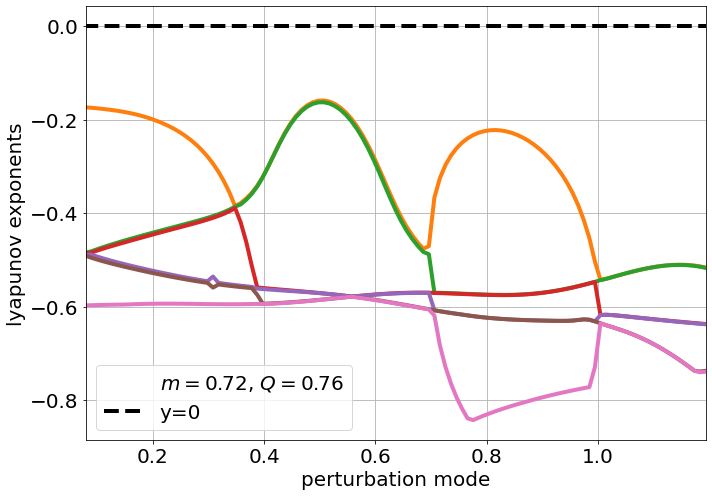

In [28]:
get_lyapunov_graph(coefs, 6)

In [20]:
p4 = "./iterations/strong/"
p1 = "./iterations/no/"
p2 = "./iterations/axis/"
p3 = "./iterations/weak/"
paths = [p1,p2,p3,p4]
data_raw = []
data_fft = []
for path in paths:
    data_raw.append(np.loadtxt(path+"res_raw.txt"))
    data_fft.append(np.loadtxt(path+"res_fft.txt"))

In [21]:
def add_subplot_axes(axx,rect,axisbg='w'):
    fig = plt.gcf()
    box = axx.get_position()
    width = box.width
    height = box.height
    inax_position  = axx.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height],facecolor=axisbg)
    subax.set_xticks([])
    subax.set_yticks([])
    return subax

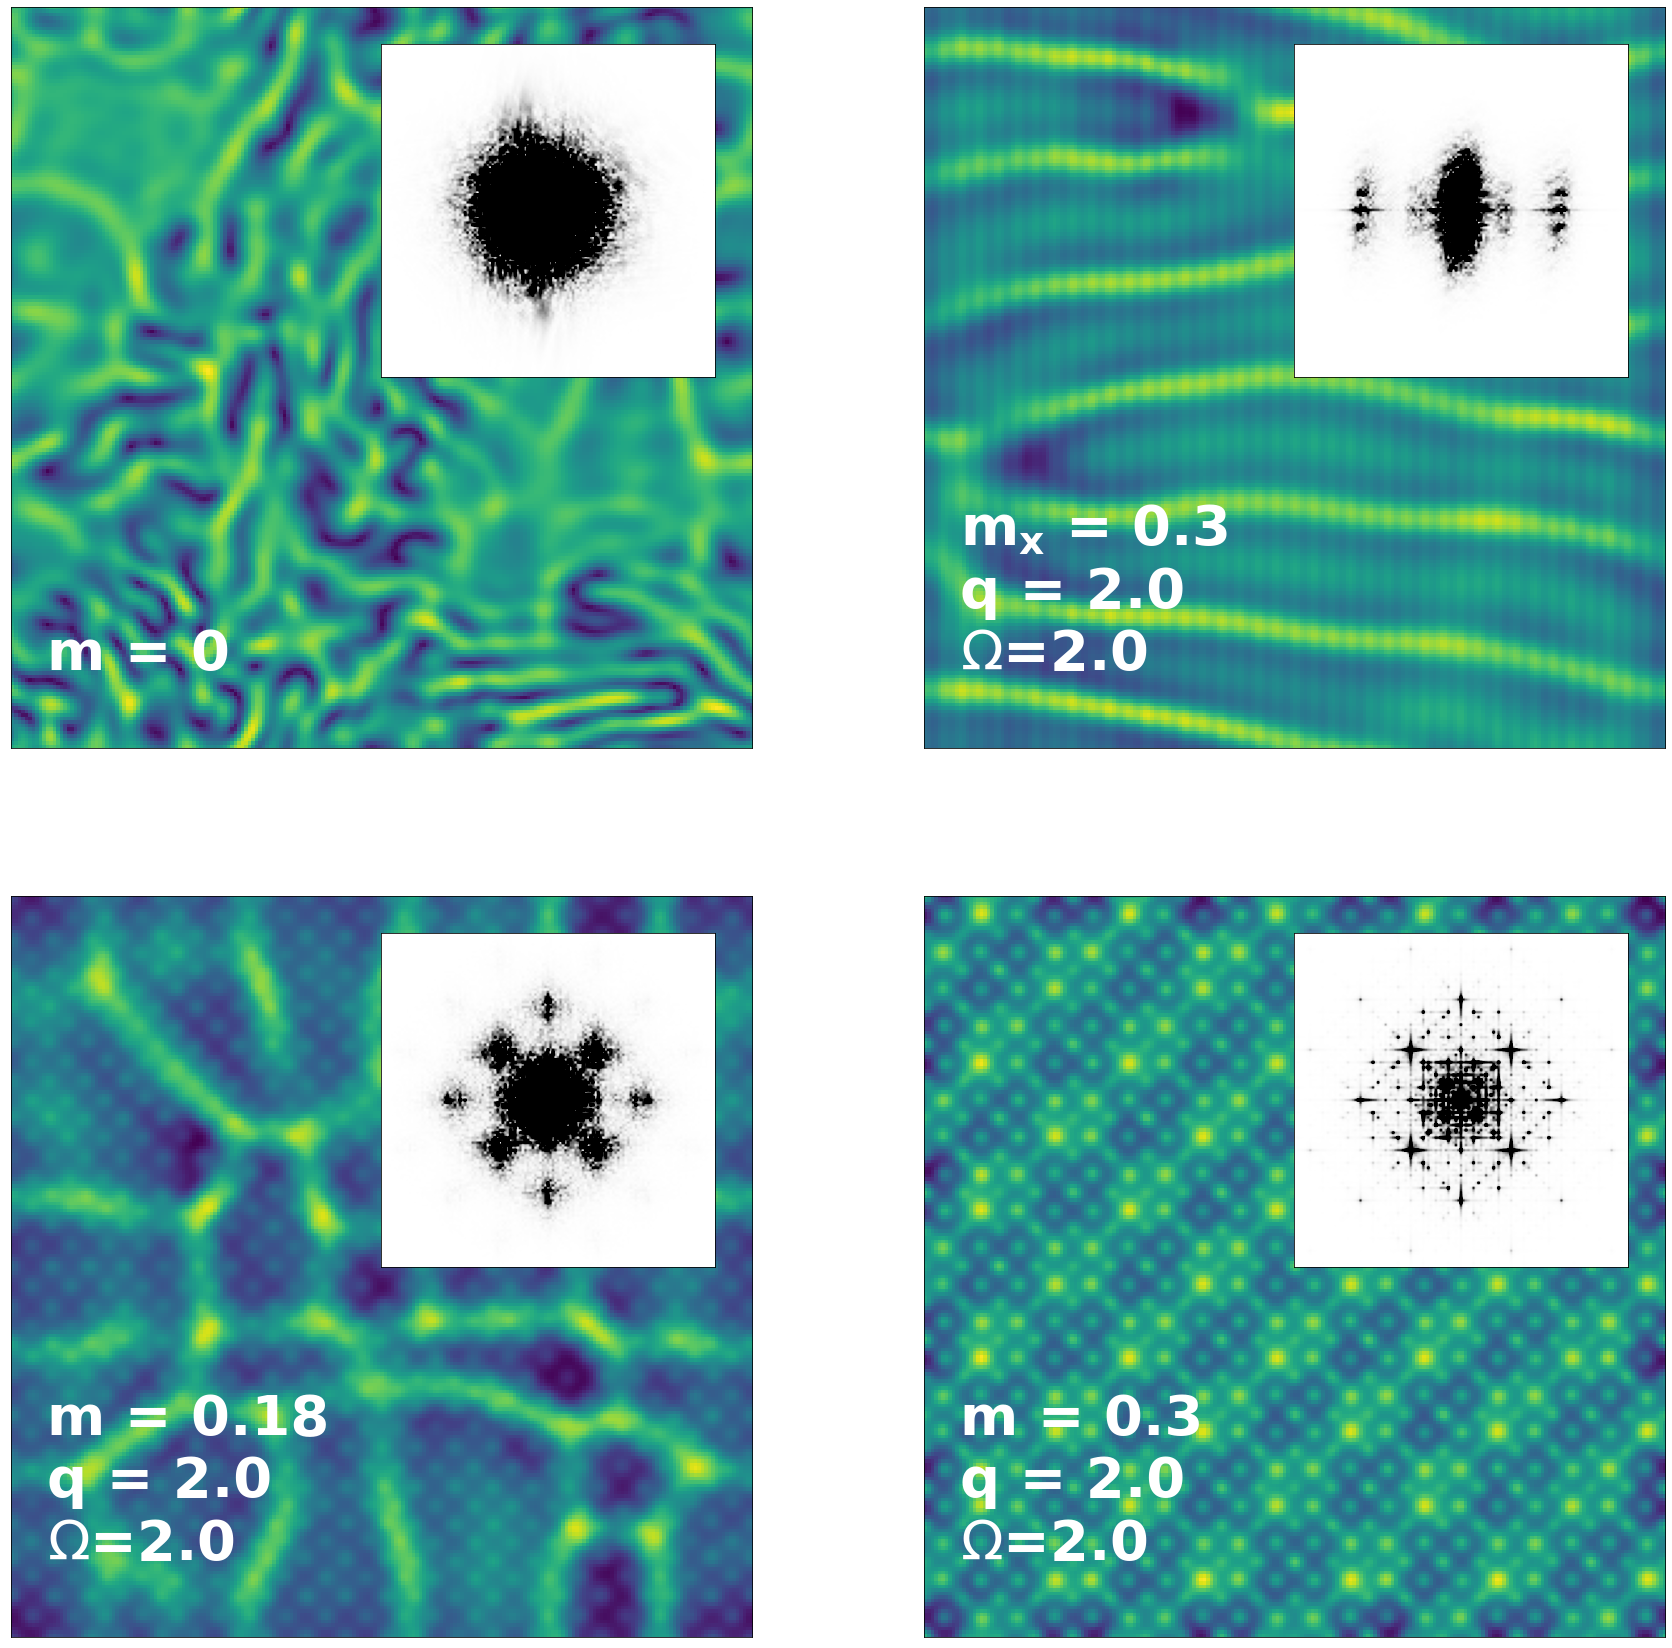

In [22]:
vmax = 25
val = 40
every = 1
# plt.tight_layout()
fig, ax = plt.subplots(2, 2, figsize=(30,30))
ax[0,0].imshow(data_raw[0])
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
rect = [0.5,0.5,0.45,0.45]
ax1 = add_subplot_axes(ax[0,0],rect)
ax1.imshow(data_fft[0][val:-val:every,val:-val:every], vmin=0.0, vmax=vmax, cmap="Greys")
ax[0,0].text(10,190,'m = 0', fontsize=56, color = "white", weight="bold")

ax[0,1].imshow(data_raw[1])
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
rect = [0.5,0.5,0.45,0.45]
ax2 = add_subplot_axes(ax[0,1],rect)
ax2.imshow(data_fft[1][val:-val:every,val:-val:every], vmin=0.0, vmax=vmax, cmap="Greys")
ax[0,1].text(10,190,'$\mathbf{m_x}$ = 0.3\nq = 2.0\n$\Omega$=2.0', fontsize=56, color = "white", weight="bold")

ax[1,0].imshow(data_raw[2])
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
rect = [0.5,0.5,0.45,0.45]
ax3 = add_subplot_axes(ax[1,0],rect)
ax3.imshow(data_fft[2][val:-val:every,val:-val:every], vmin=0.0, vmax=vmax, cmap="Greys")
ax[1,0].text(10,190,'m = 0.18\nq = 2.0\n$\Omega$=2.0', fontsize=56, color = "white", weight="bold")

ax[1,1].imshow(data_raw[3])
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
rect = [0.5,0.5,0.45,0.45]
ax4 = add_subplot_axes(ax[1,1],rect)
ax4.imshow(data_fft[3][val:-val:every,val:-val:every], vmin=0.0, vmax=vmax, cmap="Greys")
ax[1,1].text(10,190,'m = 0.3\nq = 2.0\n$\Omega$=2.0', fontsize=56, color = "white", weight="bold")
plt.savefig('2d.png')

In [23]:
n_bins = 40
cutoff = 2000
class NLSE_env(gym.Env):

    def __init__(self, m = ''):
        self.action_space = gym.spaces.Discrete(301, start=0)
        self.T_max = 13
        self.observation_space = gym.spaces.Discrete(n_bins*self.T_max, start=0)
        return

    def reset(self):
        self.obs = np.copy(A_noize)
        state = np.abs(np.fft.fft(np.abs(self.obs)))
        self.metric = np.sum(state[1:cutoff])/cutoff+np.sum(state[-cutoff:])/cutoff
        self.prev_metric = self.metric
        return 0, self.metric

    def step(self, action, time):
        m = (action-150)*0.01
        #print("m", m)

        A = torch.tensor(self.obs)
        A, heatmap_1D, _ = iterations(A, num = 1, Om = 0,
                                     m = [m], q = [q*2*np.pi])

        res = np.abs(np.fft.fft(heatmap_1D, axis=1)[:, :])
        metric = np.sum(res[-1][1:cutoff])/cutoff + np.sum(res[-1][-cutoff:])/cutoff
        reward = 1./(abs(self.prev_metric-metric)+0.01)*time*time/1000. if metric < self.metric else -100.*time*time
        self.prev_metric = metric
        #reward = -metric/100*time*time

        self.obs = A.numpy()
        #print(time, reward)
        return reward, metric
        

In [24]:
env = NLSE_env()

In [25]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])
print(q_table.shape)

(520, 301)


In [222]:
# import pickle

# with open(r"actions_3.pickle", "wb") as output_file:
#     pickle.dump(actions_backup, output_file)

In [223]:
def ind_from_state(state, low_freq):
    val = int(low_freq) if low_freq < 39 else 39
    ind = val + state * n_bins
    return int(ind)

In [26]:
Alpha = 0.1
Gamma = 0.6
Epsilon = 0.1

T = 4000
max_epoch = 8000
actions = np.zeros(max_epoch)


stop = False

for _ in tqdm(range(T)):
    if T==1:
        q_table = np.copy(backup)
    else:
        q_backup = np.copy(q_table)
    st, low_freq = env.reset()
    ind = ind_from_state(st, low_freq)
    reward = 0
    for epoch in range(max_epoch):
        crit_val = random.uniform(0, 1)
        if T==1:
            action = int(actions_backup[epoch])
        elif crit_val < Epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[ind])

        actions[epoch] = action    

        reward, low_freq = env.step(action, epoch)
        old_value = q_table[ind, action]
        new_ind = ind_from_state((epoch+1)%env.T_max, low_freq)
        next_max = np.max(q_table[new_ind])

        new_value = (1 - Alpha) * old_value + Alpha * (reward + Gamma * next_max)
        q_table[ind, action] = new_value

        ind = new_ind

    if low_freq < 2.1:
        print("breaking:", low_freq)
        actions_backup = np.copy(actions)
        break
    if T == 1:
        print(low_freq)

print("Training finished.\n")


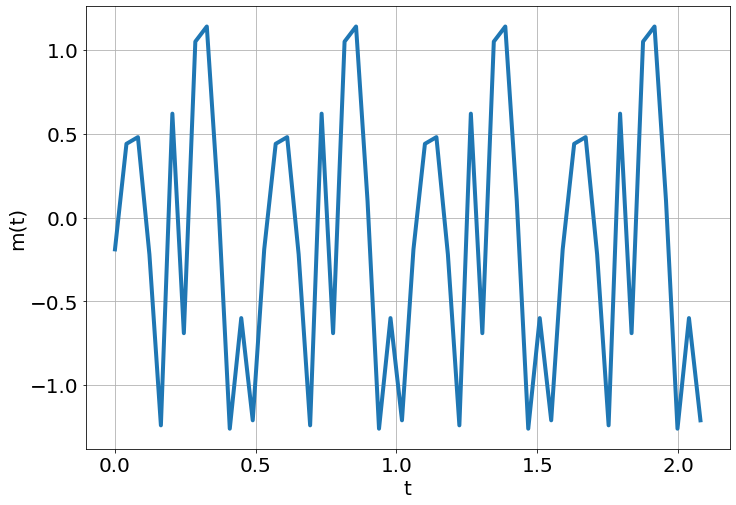

In [312]:
plt.figure(figsize=(10,7))

plt.plot(np.linspace(0, 4*13*0.04, 4*13), (np.array(actions_backup[-4*13:])-150)*0.01, lw=4)
#plt.plot(np.linspace(0, 4*13*0.04, 4*13), np.cos(12.16*np.linspace(0, 4*13*0.04, 4*13)), lw=4)


plt.ylabel("m(t)", fontsize=20)
plt.xlabel("t", fontsize=20)
plt.tight_layout()
plt.grid()
#plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("RL_modulation_1.png")

In [135]:
#noize_backup = np.copy(actions_backup)

In [136]:
#backup = np.copy(q_table)

In [20]:
modulation = np.copy(actions_backup[-13:])

13


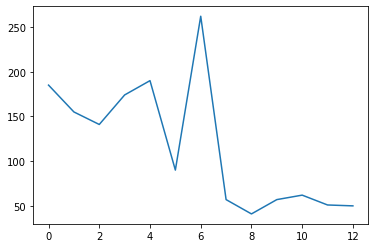

In [21]:
plt.plot(modulation)
print(len(modulation))